In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm

In [98]:
# OAI dataset
df = pd.read_csv("preprocessed_OAI.csv")
# GLAD dataset
dfg = pd.read_csv("preprocessed_Glad.csv")
df.shape
print("OAI shape:", df.shape, "GLAD shape:", dfg.shape)

OAI shape: (4131, 11) GLAD shape: (7603, 11)


In [99]:
df.columns

Index(['V00AGE', 'P02SEX', 'P01BMI', 'V00CESD6', 'V00CEMPLOY_employment',
       'PA_baseline_category', 'PA_followup_category', 'V00KOOSQOL',
       'V01KOOSQOL', 'knee_pain_baseline', 'knee_pain_follow'],
      dtype='object')

In [100]:
dfg

,age,gender,fysb_BMI,ptb_14618_depression,ptb_3777_employment,ptb_4145,pt12_4145,ptb_koos_qol_score,pt12_koos_qol_score,ptb_3764,pt12_3764
0,50,2,22.68,1.0,1.0,10.0,10.0,31.25,56.25,65.0,17.0
1,45,1,29.07,1.0,1.0,7.0,10.0,25.00,43.75,96.0,52.0
2,46,2,26.10,1.0,1.0,3.0,9.0,68.75,62.50,39.0,25.0
3,53,2,28.03,1.0,1.0,4.0,4.0,62.50,87.50,15.0,2.0
4,68,2,27.82,1.0,1.0,8.0,10.0,87.50,93.75,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1.0,1.0,8.0,10.0,50.00,56.25,57.0,9.0
7599,61,2,29.34,1.0,1.0,3.0,6.0,25.00,68.75,55.0,8.0
7600,62,1,25.88,1.0,1.0,3.0,3.0,50.00,25.00,26.0,77.0
7601,47,2,26.51,1.0,1.0,4.0,2.0,43.75,18.75,47.0,92.0


##### Rename columns

In [101]:
# Renaming columns in df for consistency
df.rename(columns={
    'V00AGE': 'Age',
    'P02SEX': 'Gender',
    'P01BMI': 'BMI',
    'V00CESD6': 'Depression',
    'V00CEMPLOY_employment': 'Employment_status',
    'V00KOOSQOL': 'Baseline_Quality_of_life',
    'V01KOOSQOL': 'Followup_Quality_of_life',
    'knee_pain_baseline': 'Baseline_Pain',
    'knee_pain_follow': 'Followup_Pain',
    'PA_baseline_category': 'Baseline_Physical_Activity',
    'PA_followup_category': 'Followup_Physical_Activity'
}, inplace=True)

dfg.rename(columns={
    'age': 'Age',
    'gender': 'Gender',
    'fysb_BMI': 'BMI',
    'ptb_14618_depression': 'Depression',
    'ptb_3777_employment': 'Employment_status',
    'ptb_koos_qol_score': 'Baseline_Quality_of_life',
    'pt12_koos_qol_score': 'Followup_Quality_of_life',
    'ptb_3764': 'Baseline_Pain',
    'pt12_3764': 'Followup_Pain',
    'ptb_4145': 'Baseline_Physical_Activity',
    'pt12_4145': 'Followup_Physical_Activity'
}, inplace=True)


##### Create outcome

In [102]:
# OAI dataset
##### Physical activity
# Ensure the columns are of type 'category'
df['Followup_Physical_Activity'] = df['Followup_Physical_Activity'].astype('category')
df['Baseline_Physical_Activity'] = df['Baseline_Physical_Activity'].astype('category')

# Convert categories to codes if they are ordinal
df['Followup_Physical_Activity'] = df['Followup_Physical_Activity'].cat.codes
df['Baseline_Physical_Activity'] = df['Baseline_Physical_Activity'].cat.codes

df['PA_change'] = df['Followup_Physical_Activity'] - df['Baseline_Physical_Activity']

##### Quality of life
df['QOL_change'] = df['Followup_Quality_of_life'] - df['Baseline_Quality_of_life']

##### Pain
df['pain_change'] = df['Followup_Pain'] - df['Baseline_Pain']

In [103]:
dfg

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Followup_Quality_of_life,Baseline_Pain,Followup_Pain
0,50,2,22.68,1.0,1.0,10.0,10.0,31.25,56.25,65.0,17.0
1,45,1,29.07,1.0,1.0,7.0,10.0,25.00,43.75,96.0,52.0
2,46,2,26.10,1.0,1.0,3.0,9.0,68.75,62.50,39.0,25.0
3,53,2,28.03,1.0,1.0,4.0,4.0,62.50,87.50,15.0,2.0
4,68,2,27.82,1.0,1.0,8.0,10.0,87.50,93.75,15.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7598,55,2,35.63,1.0,1.0,8.0,10.0,50.00,56.25,57.0,9.0
7599,61,2,29.34,1.0,1.0,3.0,6.0,25.00,68.75,55.0,8.0
7600,62,1,25.88,1.0,1.0,3.0,3.0,50.00,25.00,26.0,77.0
7601,47,2,26.51,1.0,1.0,4.0,2.0,43.75,18.75,47.0,92.0


In [104]:
# GLAD Dataset
##### Physical activity
dfg['Baseline_Physical_Activity'] = dfg['Baseline_Physical_Activity'].astype('category')
dfg['Baseline_Physical_Activity'] = dfg['Baseline_Physical_Activity'].cat.codes

dfg['Followup_Physical_Activity'] = dfg['Followup_Physical_Activity'].astype('category')
dfg['Followup_Physical_Activity'] = dfg['Followup_Physical_Activity'].cat.codes

dfg['PA_change'] = dfg['Followup_Physical_Activity'] - dfg['Baseline_Physical_Activity']

##### Quality of life
dfg['QOL_change'] = dfg['Followup_Quality_of_life'] - dfg['Baseline_Quality_of_life']

##### Pain
dfg['pain_change'] = dfg['Followup_Pain'] - dfg['Baseline_Pain']


In [105]:
df.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'Baseline_Physical_Activity', 'Followup_Physical_Activity',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'Baseline_Pain',
       'Followup_Pain', 'PA_change', 'QOL_change', 'pain_change'],
      dtype='object')

In [106]:
dfg.columns

Index(['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
       'Baseline_Physical_Activity', 'Followup_Physical_Activity',
       'Baseline_Quality_of_life', 'Followup_Quality_of_life', 'Baseline_Pain',
       'Followup_Pain', 'PA_change', 'QOL_change', 'pain_change'],
      dtype='object')

##### Combine DataFrames and Prepare Data

In [107]:
df_clean = df.drop(columns=['QOL_change', 'pain_change'])
dfg_clean = dfg.drop(columns=['QOL_change', 'pain_change'])

In [108]:
# Add treatment indicators
df_clean['treatment'] = 0  # Control group
dfg_clean['treatment'] = 1  # Treatment group

# Combine dataframes
data = pd.concat([df_clean, dfg_clean])

# Define outcome and treatment
Y = data['PA_change']
D = data['treatment']

# Define matching variables (excluding the outcome and treatment indicators)
matching_vars = ['Age', 'Gender', 'BMI', 'Depression', 'Employment_status',
                 'Baseline_Physical_Activity', 'Baseline_Quality_of_life', 'Baseline_Pain']

# Create matrix of matching variables
X = data[matching_vars].values

#####  Define the Entropy Balancing Function

In [109]:
def entropy_balance(D, X):
    # Initial weights
    initial_weights = np.ones(len(X))

    def objective(w):
        return np.sum(w * np.log(w))

    def constraints(w):
        treated_mean = np.dot(w[D == 1], X[D == 1]) / np.sum(w[D == 1])
        control_mean = np.dot(w[D == 0], X[D == 0]) / np.sum(w[D == 0])
        return treated_mean - control_mean

    # Define constraint dictionary
    cons = [{'type': 'eq', 'fun': constraints}]

    # Minimize the objective function
    result = minimize(objective, initial_weights, constraints=cons, method='SLSQP', options={'disp': True})

    return result.x

weights = entropy_balance(D.values, X)

# Assign weights to the dataframe
data['weights'] = weights


/var/folders/rn/9h9wnd_x13930h39r4t9tt_w0000gr/T/ipykernel_43885/3324886334.py:6: RuntimeWarning: invalid value encountered in log
  return np.sum(w * np.log(w))


Iteration limit reached    (Exit mode 9)
            Current function value: -2335.446358781961
            Iterations: 100
            Function evaluations: 1173788
            Gradient evaluations: 100


##### Apply Weights and Analyze the Outcome

In [110]:
# Treatment group
data_treated = data[data['treatment'] == 1].copy()
data_treated['weights'] = 1

# Control group
data_control = data[data['treatment'] == 0].copy()
data_control['weights'] = weights[D == 0]

# Combine the datasets
data_balanced = pd.concat([data_treated, data_control])

# Define the outcome and treatment
Y_balanced = data_balanced['PA_change']
D_balanced = data_balanced['treatment']

# Add constant for the intercept
X_balanced = sm.add_constant(D_balanced)

# Fit the weighted linear model
model = sm.WLS(Y_balanced, X_balanced, weights=data_balanced['weights'])
results = model.fit()

# Print the summary
print(results.summary())

                            WLS Regression Results                            
Dep. Variable:              PA_change   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     81.67
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.85e-19
Time:                        14:46:59   Log-Likelihood:                -24894.
No. Observations:               11734   AIC:                         4.979e+04
Df Residuals:                   11732   BIC:                         4.981e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0445      0.038     -1.183      0.2

In [111]:
results

In [112]:
# Display the first few rows of the data to see the weights
print(data_balanced[['treatment', 'weights']].head())


   treatment  weights
0          1      1.0
1          1      1.0
2          1      1.0
3          1      1.0
4          1      1.0


In [113]:
# Summary statistics of the weights
print(data_balanced['weights'].describe())


count    11734.000000
mean         0.840494
std          0.255125
min          0.060163
25%          0.657011
50%          1.000000
75%          1.000000
max          1.494974
Name: weights, dtype: float64


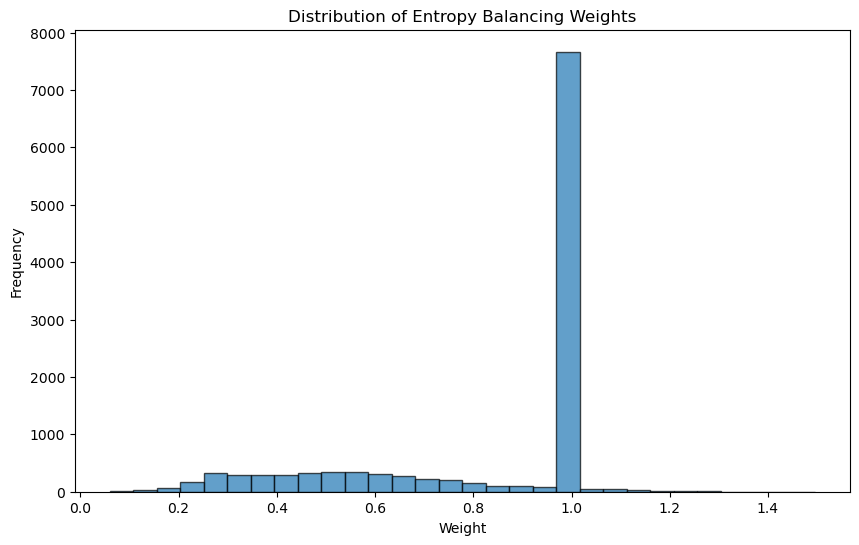

In [114]:
import matplotlib.pyplot as plt

# Plot histogram of the weights
plt.figure(figsize=(10, 6))
plt.hist(data_balanced['weights'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Entropy Balancing Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()


    Age  Gender   BMI  Depression  Employment_status  \
0  78.0     1.0  27.6         1.0                3.0   
1  76.0     2.0  27.4         1.0                3.0   
2  69.0     1.0  29.8         1.0                3.0   
3  68.0     2.0  30.1         2.0                3.0   
4  76.0     1.0  32.4         1.0                2.0   

   Baseline_Physical_Activity  Followup_Physical_Activity  \
0                           0                           0   
1                           0                           2   
2                           0                           3   
3                           0                           0   
4                           0                           0   

   Baseline_Quality_of_life  Followup_Quality_of_life  Baseline_Pain  \
0                     50.00                     68.75            8.0   
1                    100.00                     62.50            0.0   
2                     81.25                    100.00            1.0   
3       

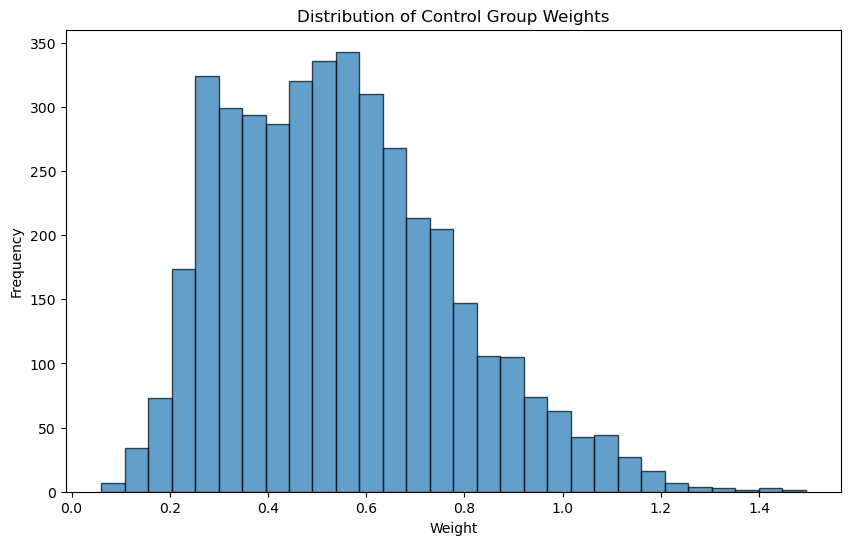

                            WLS Regression Results                            
Dep. Variable:              PA_change   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     81.67
Date:                Thu, 13 Jun 2024   Prob (F-statistic):           1.85e-19
Time:                        14:46:59   Log-Likelihood:                -24894.
No. Observations:               11734   AIC:                         4.979e+04
Df Residuals:                   11732   BIC:                         4.981e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0445      0.038     -1.183      0.2

In [115]:
# Treatment group
data_treated = data[data['treatment'] == 1].copy()
data_treated['weights'] = 1

# Control group
data_control = data[data['treatment'] == 0].copy()
data_control['weights'] = weights[D == 0]

# Display the control weighted dataset
print(data_control.head())

# Summary statistics of the control weights
print(data_control['weights'].describe())

# Plot histogram of the control weights
plt.figure(figsize=(10, 6))
plt.hist(data_control['weights'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Control Group Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

# Combine the datasets
data_balanced = pd.concat([data_treated, data_control])

# Define the outcome and treatment
Y_balanced = data_balanced['PA_change']
D_balanced = data_balanced['treatment']

# Add constant for the intercept
X_balanced = sm.add_constant(D_balanced)

# Fit the weighted linear model
model = sm.WLS(Y_balanced, X_balanced, weights=data_balanced['weights'])
results = model.fit()

# Print the summary
print(results.summary())

In [116]:
df

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Followup_Quality_of_life,Baseline_Pain,Followup_Pain,PA_change,QOL_change,pain_change
0,78.0,1.0,27.6,1.0,3.0,0,0,50.00,68.75,8.0,5.0,0,18.75,-3.0
1,76.0,2.0,27.4,1.0,3.0,0,2,100.00,62.50,0.0,4.0,2,-37.50,4.0
2,69.0,1.0,29.8,1.0,3.0,0,3,81.25,100.00,1.0,0.0,3,18.75,-1.0
3,68.0,2.0,30.1,2.0,3.0,0,0,75.00,81.25,3.0,3.0,0,6.25,0.0
4,76.0,1.0,32.4,1.0,2.0,0,0,75.00,68.75,3.0,4.0,0,-6.25,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4126,56.0,1.0,24.1,1.0,1.0,9,8,100.00,100.00,0.0,0.0,-1,0.00,0.0
4127,59.0,2.0,30.5,1.0,1.0,9,5,43.75,68.75,7.0,7.0,-4,25.00,0.0
4128,70.0,1.0,33.9,1.0,3.0,9,4,100.00,100.00,0.0,0.0,-5,0.00,0.0
4129,52.0,1.0,30.7,1.0,1.0,9,7,31.25,37.50,5.0,7.0,-2,6.25,2.0


In [117]:
data_control

,Age,Gender,BMI,Depression,Employment_status,Baseline_Physical_Activity,Followup_Physical_Activity,Baseline_Quality_of_life,Followup_Quality_of_life,Baseline_Pain,Followup_Pain,PA_change,treatment,weights
0,78.0,1.0,27.6,1.0,3.0,0,0,50.00,68.75,8.0,5.0,0,0,0.512944
1,76.0,2.0,27.4,1.0,3.0,0,2,100.00,62.50,0.0,4.0,2,0,0.244188
2,69.0,1.0,29.8,1.0,3.0,0,3,81.25,100.00,1.0,0.0,3,0,0.243399
3,68.0,2.0,30.1,2.0,3.0,0,0,75.00,81.25,3.0,3.0,0,0,0.205752
4,76.0,1.0,32.4,1.0,2.0,0,0,75.00,68.75,3.0,4.0,0,0,0.365654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4126,56.0,1.0,24.1,1.0,1.0,9,8,100.00,100.00,0.0,0.0,-1,0,0.569028
4127,59.0,2.0,30.5,1.0,1.0,9,5,43.75,68.75,7.0,7.0,-4,0,1.056456
4128,70.0,1.0,33.9,1.0,3.0,9,4,100.00,100.00,0.0,0.0,-5,0,0.242340
4129,52.0,1.0,30.7,1.0,1.0,9,7,31.25,37.50,5.0,7.0,-2,0,0.862369
